In [28]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [54]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)
K, N, T = X.shape
D=3

(108, 218, 61)


In [56]:
X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
X_normalized = X / X_norm_const

X_centered = X_normalized - jnp.mean(X_normalized, axis=0)                #(K, N, T) - (N, T) = (K, N, T)
A = jnp.swapaxes(X_centered, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                                 #(N, K*T)

In [33]:
def K_X_Y_diagonal(X, Y, sigma_sqrd):
    """For two spatial patterns X and Y, the kernel k(x_i,y_i) is equal to sum_i sigma_i^2 x_i y_i"""
    return jnp.dot(X.T * sigma_sqrd, Y) 

def K_X_Y_identity(X, Y):
    return jnp.dot(X.T, Y) 

In [57]:
K_A_X = K_X_Y_identity(A, X_normalized)                          #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [58]:
def single_pair_loss(alpha_H, K_A_X, id_1, id_2):
    K_A_X_i = K_A_X[:,id_1,:]
    K_X_A_i = K_A_X[:,id_2,:].T
    
    Q = alpha_H.T @ K_A_X_i @ K_X_A_i @ alpha_H                         #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = jnp.einsum('ij,lm->im', Q, Q)
    S_pair = jnp.trace(Q)**2 - jnp.trace(QQ_product)
    return S_pair 

def loss(alpha_tilde, P, S, K_A_X, key, i,D=3):  
    K, N, T = X.shape
    
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR


    alpha_reshaped = alpha.reshape(K,T,D)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,D)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    if i % 10 == 0:
        jax.debug.print("iteration: {}, -S: {}", i, -S)
    return -S

def update(alpha_tilde, P, S, K_A_X, optimizer, opt_state, key,i):
    grad_loss = grad(loss)(alpha_tilde, P, S, K_A_X, key,i)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, alpha_tilde)
    alpha_tilde_updated = optax.apply_updates(alpha_tilde, updates)
    return alpha_tilde_updated, opt_state_updated

def optimize_params(P, S, K_A_X, iterations=1000, learning_rate=0.001, D=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (K*T, D))
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(alpha_tilde)
    
    for i in range(iterations):
        alpha_tilde, opt_state = update(alpha_tilde, P, S, K_A_X, optimizer, opt_state, keys[i],i)

    return alpha_tilde

optimized_params = optimize_params(P, S, K_A_X)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'outputs/kernel_SCA/optimized_a_' + date_time_str
np.save(file_name, optimized_params)

iteration: 0, -S: -0.012578734196722507
iteration: 10, -S: -0.016457151621580124
iteration: 20, -S: -0.02320142835378647
iteration: 30, -S: -0.029217535629868507
iteration: 40, -S: -0.041210126131772995
iteration: 50, -S: -0.05756577104330063
iteration: 60, -S: -0.08336614072322845
iteration: 70, -S: -0.1136869341135025
iteration: 80, -S: -0.15884782373905182
iteration: 90, -S: -0.220338836312294
iteration: 100, -S: -0.32433629035949707
iteration: 110, -S: -0.46722474694252014
iteration: 120, -S: -0.6838828325271606
iteration: 130, -S: -0.9391779899597168
iteration: 140, -S: -1.3667278289794922
iteration: 150, -S: -1.8430415391921997
iteration: 160, -S: -2.7117950916290283
iteration: 170, -S: -3.76425838470459
iteration: 180, -S: -7.643592357635498
iteration: 190, -S: -11.733146667480469
iteration: 200, -S: -17.471681594848633
iteration: 210, -S: -26.077402114868164
iteration: 220, -S: -39.302791595458984
iteration: 230, -S: -57.204463958740234
iteration: 240, -S: -84.32068634033203
it

In [59]:
now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'outputs/kernel_SCA/optimized_a_' + date_time_str
np.save(file_name, optimized_params)

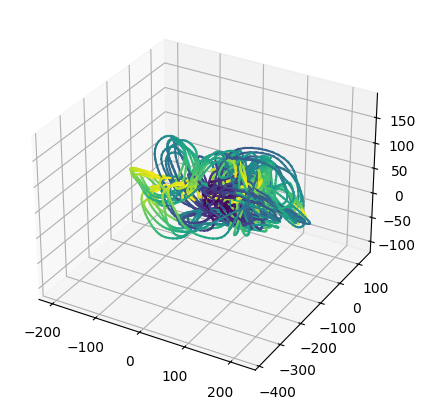

In [60]:
optimized_alpha_tilde_QR, _ = jnp.linalg.qr(optimized_params) 
optimized_alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * optimized_alpha_tilde_QR

optimized_alpha_reshaped = optimized_alpha.reshape(K,T,D)                                 #(K, T, D)
mean = jnp.mean(optimized_alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, D)
optimized_alpha_H = (optimized_alpha_reshaped - mean).reshape(K*T,D)                      #(K*T,D)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                          #(K*T,D) @ (K*T, K, T) --> (K, D, T)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]  
    y = projection[i, 1, :] 
    z = projection[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))


In [26]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 360, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path =  'outputs/kernel_SCA/' + date_time_str + "_trajectories_rotation_test.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_76715/105152096.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'15052024_155852_trajectories_rotation_test.gif'

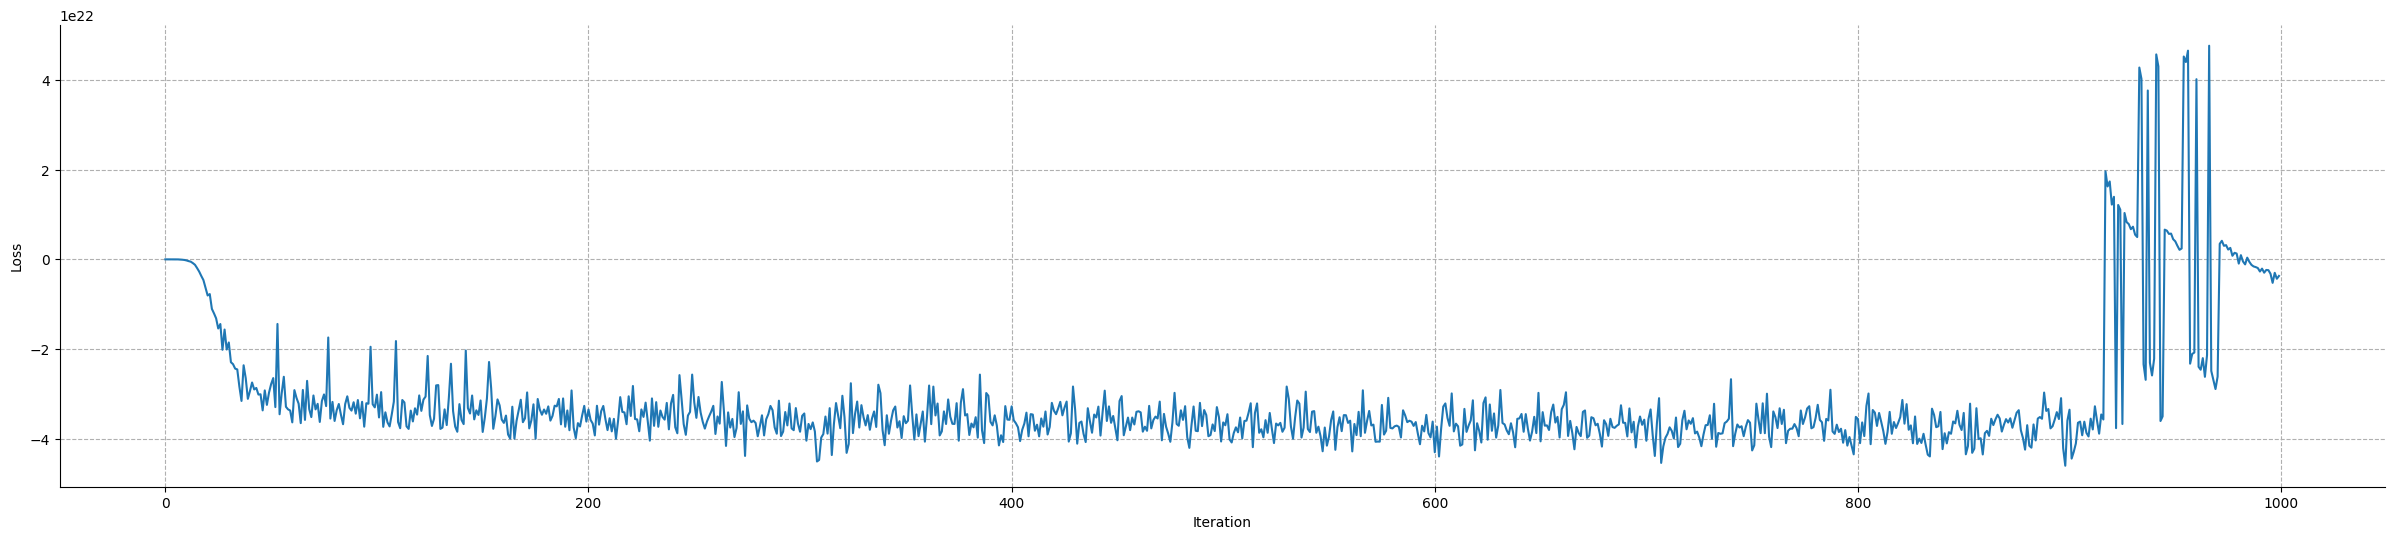

In [27]:
file_path = 'churchland_kernel_sca_15052024_155852.txt'

# List to hold the values
values = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('-S:'):
            # Split the line and extract the second part, convert it to float
            value = float(line.split(': ')[1])
            values.append(value)

# Plotting the values
plt.figure(figsize=(30, 6))
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

ENDS HERE